In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import torch
from LinearRegression import LinearRegression
plt.style.use("dark_background")

In [2]:
X,y=datasets.make_regression(n_samples=100,n_features=1,noise=20,random_state=1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)

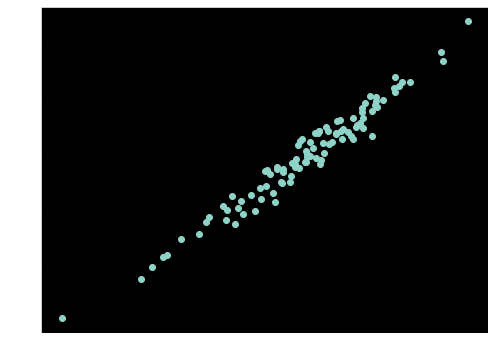

In [3]:
fig=plt.figure(figsize=(8,6))
plt.scatter(X[:,0],y)
plt.show()

In [4]:
import tenseal as ts

context=ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
context.generate_galois_keys()
context.global_scale=2**40

In [5]:
enc_X_train=[]
for i in X_train:
    t=ts.ckks_vector(context,i)
    enc_X_train.append(t)

In [6]:
enc_X_test=[]
for i in X_test:
    t=ts.ckks_vector(context,i)
    enc_X_test.append(t)

In [7]:
enc_y_train=ts.ckks_vector(context,y_train)

In [8]:
enc_y_test=ts.ckks_vector(context,y_test)

In [9]:
X_train_t=X_train.T

In [10]:
enc_X_train_t=[]
for i in X_train_t:
    t=ts.ckks_vector(context,i)
    enc_X_train_t.append(t)

In [11]:
n_samples,n_features=X_train.shape
print(n_samples,n_features)

80 1


### fit function:

In [12]:
weights=np.zeros(n_features)
weights

array([0.])

In [13]:
bias=0
var1=1/n_samples
n_iters=1000
lr=0.01

### Functions Utilized by edge computing service:

#### subtraction of y_pred and enc_y_train:

In [14]:
def subtraction_of_y_pred_and_y_actual_and_its_sum(y_pred,enc_y_train):
    y_train_1=enc_y_train.decrypt()
    y_train_1=np.array(y_train_1)
    y_pred_unenc=[]
    for i in y_pred:
        y=i.decrypt()
        y_pred_unenc.append(y[0])

    y_pred_unenc=np.array(y_pred_unenc)
    res=y_pred_unenc-y_train_1

    res_sum=res.sum()
    return res,res_sum

In [15]:
def decrypting_1d_vector(enc_vec):
    
    # enc_vec=enc_vec.decrypt()
    # enc_vec=np.array(enc_vec)
    # return enc_vec
    new_enc=[]
    for i in enc_vec:
        t=i.decrypt()
        new_enc.append(t[0])

    return new_enc

### Code and functions that are to be carried out in cloud environment:

In [16]:
for s in range(n_iters):
    if s%10==0:
        print(f'{s} iteration running')
        
    y_pred=[]
    for i in enc_X_train:
        t=i.dot(weights)
        t=t+bias
        y_pred.append(t)

    res,res_sum=subtraction_of_y_pred_and_y_actual_and_its_sum(y_pred,enc_y_train)

    # updating bias:
    db=res_sum*var1
    db=db*lr

    bias=bias-db

    # updating weights:
    dw=[]
    for i in enc_X_train_t:
        t=i.dot(res)
        dw.append(t)

    dw=decrypting_1d_vector(dw)

    for i in range(len(dw)):
        dw[i]=dw[i]*var1

    for i in range(len(dw)):
        dw[i]=dw[i]*lr

    for i in range(len(dw)):
        weights[i]=weights[i]-dw[i]

0 iteration running
10 iteration running
20 iteration running
30 iteration running
40 iteration running
50 iteration running
60 iteration running
70 iteration running
80 iteration running
90 iteration running
100 iteration running
110 iteration running
120 iteration running
130 iteration running
140 iteration running
150 iteration running
160 iteration running
170 iteration running
180 iteration running
190 iteration running
200 iteration running
210 iteration running
220 iteration running
230 iteration running
240 iteration running
250 iteration running
260 iteration running
270 iteration running
280 iteration running
290 iteration running
300 iteration running
310 iteration running
320 iteration running
330 iteration running
340 iteration running
350 iteration running
360 iteration running
370 iteration running
380 iteration running
390 iteration running
400 iteration running
410 iteration running
420 iteration running
430 iteration running
440 iteration running
450 iteration running

In [17]:
weights

array([87.40395265])

In [18]:
bias

0.9205897748769849

### testing with encrypted data:

predictions=enc_X_test*weights+bias

In [19]:
predictions=[]
for i in X_test:
    t=i.dot(weights)
    t=t+bias
    predictions.append(t)

In [20]:
for i in predictions[:5]:
    print(i)

22.57860746943084
-54.71408046760804
41.51031456594682
87.62059294584458
-195.09893977587956


In [21]:
enc_predictions=[]
for i in enc_X_test:
    t=i.dot(weights)
    t=t+bias
    enc_predictions.append(t)

In [22]:
for i in enc_predictions[:5]:
    print(i)

#### decrypting obtained values:

In [23]:
enc_predictions=decrypting_1d_vector(enc_predictions)

In [24]:
for a,b in zip(y_test,enc_predictions):
    print(a,b)

-6.400439740897028 22.57861023415664
-75.83288846408419 -54.7140879505215
43.02438482670904 41.51031984271316
81.72162477765585 87.62060459881226
-197.9801503584435 -195.09896609411265
32.09705138165424 49.29334460527997
-102.66748011552487 -77.49446982406823
15.35071412820563 11.820996333622222
6.892323119468568 26.188371517108642
26.28851287900197 7.580735769057359
-80.36899984455164 -80.03770925266403
30.84591703151775 62.51596600606065
95.06862969774186 78.46214777048617
69.43879729019481 62.472928584480655
-45.80868282540775 -29.213326584769234
63.18804079600157 42.12589198696365
91.41603362148403 91.27887212575084
-108.37740214379002 -121.61743300569694
142.75464960351508 116.39045781413283
87.77205622112535 74.42809257753116


In [25]:
def mse(y_test, enc_predictions):
    return np.mean((y_test-predictions)**2)

mse = mse(y_test, predictions)
print(mse)

304.5110881477928


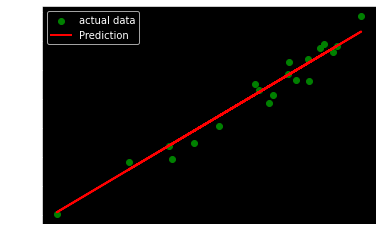

In [26]:
plt.scatter(X_test,y_test,color='green',label='actual data')
plt.plot(X_test,enc_predictions,color='red',linewidth=2,label='Prediction')
plt.legend()
plt.show()